In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
import os
import time
import json
import pickle
import random
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from random import randint


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### change `DATA_DIR` to the location where the dataset sits
### compatible datasets: ML-1M, Netflix-full

hyper_params = {
    'data_base': '/content/drive/My Drive/thesis/netflix/', # Don't remove the '/' at the end please :)
    # 'data_base': '/content/drive/My Drive/thesis/Sequential_Vae/ml-20m/', # Don't remove the '/' at the end please :)
   
    'project_name': 'svae_netflix',
    # 'data_base': 'saved_data/netflix-full/',
    # 'project_name': 'svae_netflix_full',
    'model_file_name': '',
    'log_file': '',
    'history_split_test': [0.8, 0.2], # Part of test history to train on : Part of test history to test

    'learning_rate': 0.01, # learning rate is required only if optimizer is adagrad
    'optimizer': 'adam',
    'weight_decay': float(5e-3),

    'epochs': 15,
    'batch_size': 1, # Needs to be 1, because we don't pack multiple sequences in the same batch
    
    'item_embed_size': 256,
    'rnn_size': 200,
    'hidden_size': 150,
    'latent_size': 64,
    'loss_type': 'next_k', # [predict_next, same, prefix, postfix, exp_decay, next_k]
    'next_k': 4,
    'noise': 0,

    'number_users_to_keep': 1000000000,
    'batch_log_interval': 1000,
    'train_cp_users': 200,
    'exploding_clip': 0.25,
}

file_name = '_optimizer_' + str(hyper_params['optimizer'])
if hyper_params['optimizer'] == 'adagrad':
    file_name += '_lr_' + str(hyper_params['learning_rate'])
file_name += '_weight_decay_' + str(hyper_params['weight_decay'])
file_name += '_loss_type_' + str(hyper_params['loss_type'])
file_name += '_item_embed_size_' + str(hyper_params['item_embed_size'])
file_name += '_rnn_size_' + str(hyper_params['rnn_size'])
file_name += '_latent_size_' + str(hyper_params['latent_size'])

log_file_root = "/content/drive/My Drive/thesis/netflix/saved_logfull/" # Don't remove the '/' at the end please :)
model_file_root = "/content/drive/My Drive/thesis/netflix/saved_modelsssfull/" # Don't remove the '/' at the end please :)

if not os.path.isdir(log_file_root): os.mkdir(log_file_root)
if not os.path.isdir(model_file_root): os.mkdir(model_file_root)
hyper_params['log_file'] = log_file_root + hyper_params['project_name'] + '_log' + file_name + '.txt'
hyper_params['model_file_name'] = model_file_root + hyper_params['project_name'] + '_model' + file_name + '.pt'

In [0]:
DATA_DIR = hyper_params['data_base']
pro_dir = os.path.join(DATA_DIR, 'pro_sgss') # Path where preprocessed data will be saved
hyper_params['data_base'] += 'pro_sgss/'

if not os.path.isdir(pro_dir): # We don't want to keep preprocessing every time we run the notebook
    cols = [ 'userId', 'movieId' , 'rating', 'timestamp']
    #dtypes = { 'userId': 'int', 'movieID' :'int','rating': 'int', 'timestamp': 'int'}
    #raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), sep='::', names=cols, parse_dates=['timestamp'])
    raw_data1 =pd.read_csv(os.path.join(DATA_DIR, 'answer0.csv'))

    raw_data2 =pd.read_csv(os.path.join(DATA_DIR, 'answer1.csv'))
    raw_data2 = raw_data2.drop(raw_data2.index[0])
    raw_data2[['userId','movieId','rating']] = raw_data2[['userId','movieId','rating']].apply(pd.to_numeric) 

    raw_data3= pd.read_csv(os.path.join(DATA_DIR, 'answer3.csv'))
    raw_data3 = raw_data3.drop(raw_data3.index[0])
    raw_data3 = raw_data3.drop(22601629)
    raw_data3[['userId','movieId','rating']] = raw_data3[['userId','movieId','rating']].apply(pd.to_numeric) 
    
    raw_data4 =pd.read_csv(os.path.join(DATA_DIR, 'answer4.csv'), names=cols)
    raw_data4 = raw_data4.drop(raw_data4.index[0])    
    raw_data4[['userId','movieId','rating']] = raw_data4[['userId','movieId','rating']].apply(pd.to_numeric) 
    # raw_data2 =pd.read_csv(os.path.join(DATA_DIR, 'combined_data_2.txt'), header = None, names = cols)
    # raw_data3=pd.read_csv(os.path.join(DATA_DIR, 'combined_data_3.txt'), header = None, names = cols)
    # raw_data4=pd.read_csv(os.path.join(DATA_DIR, 'combined_data_4.txt'), header = None, names = cols)
    # print (raw_data)
    max_seq_len = 1000
    n_heldout_users = 8000 # If total users = N; train_users = N - 2*heldout; test_users & val_users = heldout

    # # binarize the data (only keep ratings >= 4)
    raw_data1 = raw_data1[raw_data1['rating'] > 3.5]
    raw_data2 = raw_data2[raw_data2['rating'] > 3.5]
    raw_data3 = raw_data3[raw_data3['rating'] > 3.5]
    raw_data4 = raw_data4[raw_data4['rating'] > 3.5]

    # # Remove users with greater than $max_seq_len number of watched movies
    raw_data1 = raw_data1.groupby(["userId"]).filter(lambda x: len(x) <= max_seq_len)
    raw_data2 = raw_data2.groupby(["userId"]).filter(lambda x: len(x) <= max_seq_len)
    raw_data3 = raw_data3.groupby(["userId"]).filter(lambda x: len(x) <= max_seq_len)
    raw_data4 = raw_data4.groupby(["userId"]).filter(lambda x: len(x) <= max_seq_len)

    # # Sort data values with the timestamp
    raw_data1 = raw_data1.groupby(["userId"]).apply(lambda x: x.sort_values(["timestamp"], ascending = True)).reset_index(drop=True)
    raw_data2 = raw_data2.groupby(["userId"]).apply(lambda x: x.sort_values(["timestamp"], ascending = True)).reset_index(drop=True)
    raw_data3 = raw_data3.groupby(["userId"]).apply(lambda x: x.sort_values(["timestamp"], ascending = True)).reset_index(drop=True)
    raw_data4 = raw_data4.groupby(["userId"]).apply(lambda x: x.sort_values(["timestamp"], ascending = True)).reset_index(drop=True)


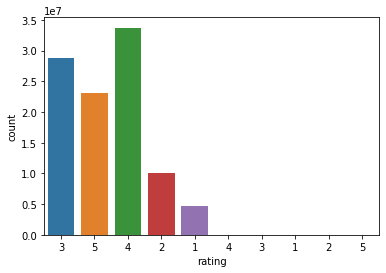

In [0]:
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
plot = sns.countplot(x="rating",data=raw_data)

plot.figure.savefig("rating_plot.pdf")
files.download("rating_plot.pdf") 

In [0]:
raw_data.describe()

,userId,movieId,rating,timestamp
count,100480505,100480505,100480505,100480505
unique,17772,536347,11,2183
top,5317,305344,4,2005-01-19
freq,232944,17644,33731611,737570


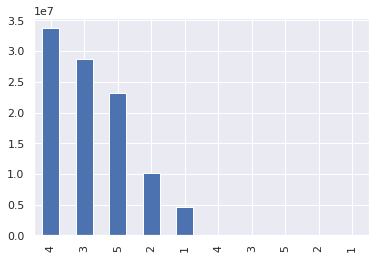

In [0]:
raw_data['rating'].value_counts().plot(kind='bar');

In [0]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            # idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True
            idx[int((1.0 - test_prop) * n_items_u):] = True
            # print(idx)
            
            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    ra = list(map(lambda x: x, tp['rating']))
    ret =  pd.DataFrame(data={'uid': uid, 'sid': sid, 'rating': ra}, columns=['uid', 'sid', 'rating'])
    ret['rating'] = ret['rating'].apply(pd.to_numeric)
    return ret

In [0]:
if not os.path.isdir(pro_dir): # We don't want to keep preprocessing every time we run the notebook

    raw_data, user_activity, item_popularity = filter_triplets(raw_data)
    sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

    print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
          (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

    unique_uid = user_activity.index

    np.random.seed(98765)
    idx_perm = np.random.permutation(unique_uid.size)
    unique_uid = unique_uid[idx_perm]

    # create train/validation/test users
    n_users = unique_uid.size

    n_heldout_users = 1000
    tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
    vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
    te_users = unique_uid[(n_users - n_heldout_users):]

    train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

    unique_sid = pd.unique(train_plays['movieId'])
    print(unique_sid)

    show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
    profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

    if not os.path.exists(pro_dir):
        os.makedirs(pro_dir)

    with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
        for sid in unique_sid:
            f.write('%s\n' % sid)

    vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
    vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

    vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

    test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
    test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

    test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

    train_data = numerize(train_plays)
    train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

    vad_data_tr = numerize(vad_plays_tr)
    vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

    vad_data_te = numerize(vad_plays_te)
    vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

    test_data_tr = numerize(test_plays_tr)
    test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

    test_data_te = numerize(test_plays_te)
    test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

In [0]:
LongTensor = torch.LongTensor
FloatTensor = torch.FloatTensor

is_cuda_available = torch.cuda.is_available()

if is_cuda_available: 
    print("Using CUDA...\n")
    LongTensor = torch.cuda.LongTensor
    FloatTensor = torch.cuda.FloatTensor
    
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def save_obj_json(obj, name):
    with open(name + '.json', 'w') as f:
        json.dump(obj, f)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_obj_json(name):
    with open(name + '.json', 'r') as f:
        return json.load(f)

def file_write(log_file, s):
    print(s)
    f = open(log_file, 'a')
    f.write(s+'\n')
    f.close()

def clear_log_file(log_file):
    f = open(log_file, 'w')
    f.write('')
    f.close()

def pretty_print(h):
    print("{")
    for key in h:
        print(' ' * 4 + str(key) + ': ' + h[key])
    print('}\n')
    
def plot_len_vs_ndcg(len_to_ndcg_at_100_map):
    
    lens = list(len_to_ndcg_at_100_map.keys())
    lens.sort()
    X, Y = [], []
    
    for le in lens:
        X.append(le)
        ans = 0.0
        for i in len_to_ndcg_at_100_map[le]: ans += float(i)
        ans = ans / float(len(len_to_ndcg_at_100_map[le]))
        Y.append(ans * 100.0)
    
    # Smoothening
    Y_mine = []
    prev_5 = []
    for i in Y:
        prev_5.append(i)
        if len(prev_5) > 5: del prev_5[0]

        temp = 0.0
        for j in prev_5: temp += float(j)
        temp = float(temp) / float(len(prev_5))
        Y_mine.append(temp)
    
    plt.figure(figsize=(12, 5))
    plt.plot(X, Y_mine, label='SVAE')
    plt.xlabel("Number of items in the fold-out set")
    plt.ylabel("Average NDCG@100")
    plt.title(hyper_params['project_name'])
    if not os.path.isdir("saved_plots/"): os.mkdir("saved_plots/")
    plt.savefig("saved_plots/seq_len_vs_ndcg_" + hyper_params['project_name'] + ".pdf")

    leg = plt.legend(loc='best', ncol=2)
    
    plt.show()

Using CUDA...



In [0]:
def load_data(hyper_params):
    
    file_write(hyper_params['log_file'], "Started reading data file")
    
    f = open(hyper_params['data_base'] + 'train.csv')
    lines_train = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'validation_tr.csv')
    lines_val_tr = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'validation_te.csv')
    lines_val_te = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'test_tr.csv')
    lines_test_tr = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'test_te.csv')
    lines_test_te = f.readlines()[1:]
    
    unique_sid = list()
    with open(hyper_params['data_base'] + 'unique_sid.txt', 'r') as f:
        for line in f:
            unique_sid.append(line.strip())
    num_items = len(unique_sid)
    
    file_write(hyper_params['log_file'], "Data Files loaded!")

    train_reader = DataReader(hyper_params, lines_train, None, num_items, True)
    val_reader = DataReader(hyper_params, lines_val_tr, lines_val_te, num_items, False)
    test_reader = DataReader(hyper_params, lines_test_tr, lines_test_te, num_items, False)

    return train_reader, val_reader, test_reader, num_items

class DataReader:
    def __init__(self, hyper_params, a, b, num_items, is_training):
        self.hyper_params = hyper_params
        self.batch_size = hyper_params['batch_size']
        
        num_users = 0
        min_user = 1000000000000000000000000 # Infinity
        for line in a:
            line = line.strip().split(",")
            num_users = max(num_users, int(line[0]))
            min_user = min(min_user, int(line[0]))
        num_users = num_users - min_user + 1
        
        self.num_users = num_users
        self.min_user = min_user
        self.num_items = num_items
        
        self.data_train = a
        self.data_test = b
        self.is_training = is_training
        self.all_users = []
        
        self.prep()
        self.number()

    def prep(self):
        self.data = []
        for i in range(self.num_users): self.data.append([])
            
        for i in tqdm(range(len(self.data_train))):
            line = self.data_train[i]
            line = line.strip().split(",")
            self.data[int(line[0]) - self.min_user].append([ int(line[1]), 1 ])
        
        if self.is_training == False:
            self.data_te = []
            for i in range(self.num_users): self.data_te.append([])
                
            for i in tqdm(range(len(self.data_test))):
                line = self.data_test[i]
                line = line.strip().split(",")
                self.data_te[int(line[0]) - self.min_user].append([ int(line[1]), 1 ])
                
        
    def number(self):
        self.num_b = int(min(len(self.data), self.hyper_params['number_users_to_keep']) / self.batch_size)
    
    def iter(self):
        users_done = 0

        x_batch = []
        
        user_iterate_order = list(range(len(self.data)))
        
        # Randomly shuffle the training order
        np.random.shuffle(user_iterate_order)
        
        for user in user_iterate_order:

            if users_done > self.hyper_params['number_users_to_keep']: break
            users_done += 1
            
            y_batch_s = torch.zeros(self.batch_size, len(self.data[user]) - 1, self.num_items)
            if is_cuda_available: y_batch_s = y_batch_s.cuda()
            
            if self.hyper_params['loss_type'] == 'predict_next':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in [ self.data[user][timestep + 1] ] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'next_k':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in self.data[user][timestep + 1:][:self.hyper_params['next_k']] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'postfix':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in self.data[user][timestep + 1:] ]), 1.0
                    )
            
            x_batch.append([ i[0] for i in self.data[user][:-1] ])
            
            if len(x_batch) == self.batch_size: # batch_size always = 1
            
                yield Variable(LongTensor(x_batch)), Variable(y_batch_s, requires_grad=False)
                x_batch = []

    def iter_eval(self):

        x_batch = []
        test_movies, test_movies_r = [], []
        
        users_done = 0
        
        for user in range(len(self.data)):
            
            users_done += 1
            if users_done > self.hyper_params['number_users_to_keep']: break
            
            if self.is_training == True: 
                split = float(self.hyper_params['history_split_test'][0])
                base_predictions_on = self.data[user][:int(split * len(self.data[user]))]
                heldout_movies = self.data[user][int(split * len(self.data[user])):]
            else:
                base_predictions_on = self.data[user]
                heldout_movies = self.data_te[user]
            
            y_batch_s = torch.zeros(self.batch_size, len(base_predictions_on) - 1, self.num_items).cuda()
            
            if self.hyper_params['loss_type'] == 'predict_next':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in [ base_predictions_on[timestep + 1] ] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'next_k':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in base_predictions_on[timestep + 1:][:self.hyper_params['next_k']] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'postfix':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in base_predictions_on[timestep + 1:] ]), 1.0
                    )
            
            test_movies.append([ i[0] for i in heldout_movies ])
            test_movies_r.append([ i[1] for i in heldout_movies ])
            x_batch.append([ i[0] for i in base_predictions_on[:-1] ])
            
            if len(x_batch) == self.batch_size: # batch_size always = 1
                
                yield Variable(LongTensor(x_batch)), Variable(y_batch_s, requires_grad=False), test_movies, test_movies_r
                x_batch = []
                test_movies, test_movies_r = [], []

In [0]:
def evaluate(model, criterion, reader, hyper_params, is_train_set):
    model.eval()

    metrics = {}
    metrics['loss'] = 0.0
    Ks = [10, 100]
    for k in Ks: 
        metrics['NDCG@' + str(k)] = 0.0
        metrics['Rec@' + str(k)] = 0.0
        metrics['Prec@' + str(k)] = 0.0

    batch = 0.0
    total_users = 0.0
    print (total_users)
    # For plotting the results (seq length vs. NDCG@100)
    len_to_ndcg_at_100_map = {}

    for x, y_s, test_movies, test_movies_r in reader.iter_eval():
        #print(x, y_s, test_movies, test_movies_r)
        batch += 1
        if is_train_set == True and batch > hyper_params['train_cp_users']: break
        #if is_train_set == False:
          #hyper_params['noise']= noise
        decoder_output, z_mean, z_log_sigma = model(x)
        #print('output decoder')
        #print(decoder_output.shape)
        metrics['loss'] += criterion(decoder_output, z_mean, z_log_sigma, y_s, 0.2).data
        
        # Making the logits of previous items in the sequence to be "- infinity"
        decoder_output = decoder_output.data
        #print('after decoder after criterian')
        #print(decoder_output.shape)
        x_scattered = torch.zeros(decoder_output.shape[0], decoder_output.shape[2])
        #print('x_scattered')
        #print(x_scattered.shape)
        if is_cuda_available: x_scattered = x_scattered.cuda()
        #print('x scattered after ')
        x_scattered[0, :].scatter_(0, x[0].data, 1.0)

        last_predictions = decoder_output[:, -1, :] - (torch.abs(decoder_output[:, -1, :] * x_scattered) * 100000000)
        #print('last pred')
        #print(last_predictions.shape)
        for batch_num in range(last_predictions.shape[0]): # batch_num is ideally only 0, since batch_size is enforced to be always 1
            predicted_scores = last_predictions[batch_num]
            #print('score')
            #print(predicted_scores.shape)

            actual_movies_watched = test_movies[batch_num]
            actual_movies_ratings = test_movies_r[batch_num]
                    
            # Calculate NDCG
            _, argsorted = torch.sort(-1.0 * predicted_scores)
            for k in Ks:
                best, now_at, dcg, hits = 0.0, 0.0, 0.0, 0.0
                
                rec_list = list(argsorted[:k].cpu().numpy())
                for m in range(len(actual_movies_watched)):
                    movie = actual_movies_watched[m]
                    now_at += 1.0
                    if now_at <= k: best += 1.0 / float(np.log2(now_at + 1))
                    
                    if movie not in rec_list: continue
                    hits += 1.0
                    dcg += 1.0 / float(np.log2(float(rec_list.index(movie) + 2)))
                
                metrics['NDCG@' + str(k)] += float(dcg) / float(best)
                metrics['Rec@' + str(k)] += float(hits) / float(len(actual_movies_watched))
                metrics['Prec@' + str(k)] += float(hits) / float(k)
                
                # Only for plotting the graph (seq length vs. NDCG@100)
                if k == 100:
                    seq_len = int(len(actual_movies_watched)) + int(x[batch_num].shape[0]) + 1
                    if seq_len not in len_to_ndcg_at_100_map: len_to_ndcg_at_100_map[seq_len] = []
                    len_to_ndcg_at_100_map[seq_len].append(float(dcg) / float(best))
                
            total_users += 1.0
    metrics['loss'] = float(metrics['loss']) / float(batch)
    metrics['loss'] = round(metrics['loss'], 4)
    
    for k in Ks:
        metrics['NDCG@' + str(k)] = round((100.0 * metrics['NDCG@' + str(k)]) / float(total_users), 4)
        metrics['Rec@' + str(k)] = round((100.0 * metrics['Rec@' + str(k)]) / float(total_users), 4)
        metrics['Prec@' + str(k)] = round((100.0 * metrics['Prec@' + str(k)]) / float(total_users), 4)
        
    return metrics, len_to_ndcg_at_100_map

In [0]:
s_noise = None

In [0]:
class Encoder(nn.Module):
    def __init__(self, hyper_params):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(
            hyper_params['rnn_size'], hyper_params['hidden_size']
        )
        nn.init.xavier_normal(self.linear1.weight)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        return x

class Decoder(nn.Module):
    def __init__(self, hyper_params):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(hyper_params['latent_size'], hyper_params['hidden_size'])
        self.linear2 = nn.Linear(hyper_params['hidden_size'], hyper_params['total_items'])
        nn.init.xavier_normal(self.linear1.weight)
        nn.init.xavier_normal(self.linear2.weight)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

class Model(nn.Module):
    def __init__(self, hyper_params):
        super(Model, self).__init__()
        self.hyper_params = hyper_params
        # self.noise = hyper_params['noise'] 
        self.encoder = Encoder(hyper_params)
        self.decoder = Decoder(hyper_params)
        
        # Since we don't need padding, our vocabulary size = "hyper_params['total_items']" and not "hyper_params['total_items'] + 1"
        self.item_embed = nn.Embedding(hyper_params['total_items'], hyper_params['item_embed_size'])
        
        self.gru = nn.GRU(
            hyper_params['item_embed_size'], hyper_params['rnn_size'], 
            batch_first = True, num_layers = 1
        )
        
        self.linear1 = nn.Linear(hyper_params['hidden_size'], 2 * hyper_params['latent_size'])
        nn.init.xavier_normal(self.linear1.weight)
        
        self.tanh = nn.Tanh()
    
    def add_noise(self, noise, sigma):
        # print("Input Noise: ", noise)
        return {
           1: torch.from_numpy(np.random.normal(0, 0.5, size=sigma.size())).float(),
           2: torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float(),
           3: torch.from_numpy(np.random.normal(0, 2, size=sigma.size())).float(),
           4: torch.from_numpy(np.random.uniform(-1, 1, size=sigma.size())).float(),
        }.get(noise, torch.zeros(1))
          
    def sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        temp_out = self.linear1(h_enc)
        
        mu = temp_out[:, :self.hyper_params['latent_size']]
        log_sigma = temp_out[:, self.hyper_params['latent_size']:]
        
        sigma = torch.exp(log_sigma)
#         std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()
#         if is_cuda_available: std_z = std_z.cuda()

        self.z_mean = mu
        self.z_log_sigma = log_sigma
        
        #noise = self.add_noise(2, sigma)
        #if is_cuda_available: noise = noise.cuda()  
        
        std_z = self.add_noise(s_noise, sigma)  
        # std_z = self.add_noise(self.noise, sigma)        
        # std_z = self.add_noise(self.hyper_params['noise'], sigma)
        if is_cuda_available: std_z = std_z.cuda()
        return mu + sigma * Variable(std_z, requires_grad=False)
        #return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
#         return mu + noise * Variable(std_z, requires_grad=False)  # Reparameterization trick
#         return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, x):
        in_shape = x.shape                                      # [bsz x seq_len] = [1 x seq_len]
        x = x.view(-1)                                          # [seq_len]
        
        x = self.item_embed(x)                                  # [seq_len x embed_size]
        x = x.view(in_shape[0], in_shape[1], -1)                # [1 x seq_len x embed_size]
        
        rnn_out, _ = self.gru(x)                                # [1 x seq_len x rnn_size]
        rnn_out = rnn_out.view(in_shape[0] * in_shape[1], -1)   # [seq_len x rnn_size]
        
        enc_out = self.encoder(rnn_out)                         # [seq_len x hidden_size]
        sampled_z = self.sample_latent(enc_out)                 # [seq_len x latent_size]
        
        dec_out = self.decoder(sampled_z)                       # [seq_len x total_items]
        dec_out = dec_out.view(in_shape[0], in_shape[1], -1)    # [1 x seq_len x total_items]
                              
        return dec_out, self.z_mean, self.z_log_sigma

In [0]:
class VAELoss(torch.nn.Module):
    def __init__(self, hyper_params):
        super(VAELoss,self).__init__()
        self.hyper_params = hyper_params

    def forward(self, decoder_output, mu_q, logvar_q, y_true_s, anneal):
        # Calculate KL Divergence loss
        kld = torch.mean(torch.sum(0.5 * (-logvar_q + torch.exp(logvar_q) + mu_q**2 - 1), -1))
    
        # Calculate Likelihood
        dec_shape = decoder_output.shape # [batch_size x seq_len x total_items] = [1 x seq_len x total_items]

        decoder_output = F.log_softmax(decoder_output, -1)
        num_ones = float(torch.sum(y_true_s[0, 0]))
        
        likelihood = torch.sum(
            -1.0 * y_true_s.view(dec_shape[0] * dec_shape[1], -1) * \
            decoder_output.view(dec_shape[0] * dec_shape[1], -1)
        ) / (float(self.hyper_params['batch_size']) * num_ones)
        
        final = (anneal * kld) + (likelihood)
        
        return final

Started reading data file
Data Files loaded!


100%|██████████| 41234/41234 [00:00<00:00, 838868.94it/s]




Simulation run on: 2020-04-10 14:23:27.462209


Data reading complete!
Number of train batches: 10615
Number of validation batches: 1000
Number of test batches: 1000
Total Items: 275893

Model(
  (encoder): Encoder(
    (linear1): Linear(in_features=200, out_features=150, bias=True)
    (activation): Tanh()
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=64, out_features=150, bias=True)
    (linear2): Linear(in_features=150, out_features=275893, bias=True)
    (activation): Tanh()
  )
  (item_embed): Embedding(275893, 256)
  (gru): GRU(256, 200, batch_first=True)
  (linear1): Linear(in_features=150, out_features=128, bias=True)
  (tanh): Tanh()
)

Model Built!
Starting Training...

Exiting from training early


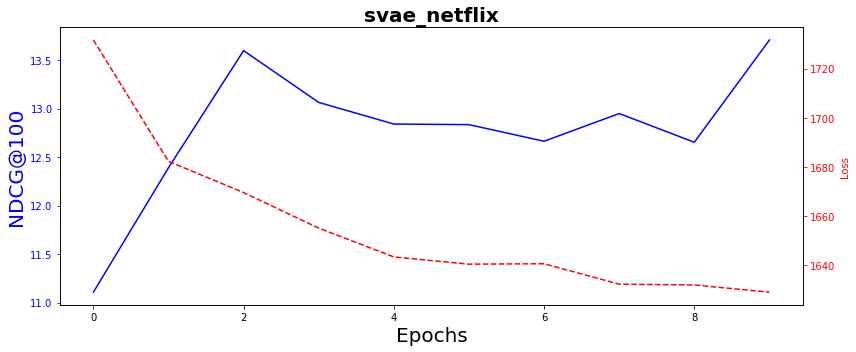

KeyboardInterrupt: ignored

In [0]:
def train(reader):
    model.train()
    
    total_loss = 0
    start_time = time.time()
    batch = 0
    batch_limit = int(train_reader.num_b)
    total_anneal_steps = 200000
    anneal = 0.0
    update_count = 0.0
    anneal_cap = 0.2
    
    for x, y_s in reader.iter():
        
        batch += 1
        
        # Empty the gradients
        model.zero_grad()
        optimizer.zero_grad()
    
        # Forward pass
        decoder_output, z_mean, z_log_sigma = model(x)
        
        # Backward pass
        loss = criterion(decoder_output, z_mean, z_log_sigma, y_s, anneal)
        loss.backward()
        optimizer.step()

        total_loss += loss.data
        
        # Anneal logic
        if total_anneal_steps > 0:
            anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
        else:
            anneal = anneal_cap
        update_count += 1.0
        
        # Logging mechanism
        if (batch % hyper_params['batch_log_interval'] == 0 and batch > 0) or batch == batch_limit:
            div = hyper_params['batch_log_interval']
            if batch == batch_limit: div = (batch_limit % hyper_params['batch_log_interval']) - 1
            if div <= 0: div = 1

            cur_loss = (total_loss / div)
            elapsed = time.time() - start_time
            
            ss = '| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.4f}'.format(
                    epoch, batch, batch_limit, (elapsed * 1000) / div, cur_loss
            )
            
            file_write(hyper_params['log_file'], ss)

            total_loss = 0
            start_time = time.time()

# Train It..
train_reader, val_reader, test_reader, total_items = load_data(hyper_params)
hyper_params['total_items'] = total_items
hyper_params['testing_batch_limit'] = test_reader.num_b

file_write(hyper_params['log_file'], "\n\nSimulation run on: " + str(dt.datetime.now()) + "\n\n")
file_write(hyper_params['log_file'], "Data reading complete!")
file_write(hyper_params['log_file'], "Number of train batches: {:4d}".format(train_reader.num_b))
file_write(hyper_params['log_file'], "Number of validation batches: {:4d}".format(val_reader.num_b))
file_write(hyper_params['log_file'], "Number of test batches: {:4d}".format(test_reader.num_b))
file_write(hyper_params['log_file'], "Total Items: " + str(total_items) + "\n")

model = Model(hyper_params)
if is_cuda_available: model.cuda()

criterion = VAELoss(hyper_params)

if hyper_params['optimizer'] == 'adagrad':
    optimizer = torch.optim.Adagrad(
        model.parameters(), weight_decay=hyper_params['weight_decay'], lr = hyper_params['learning_rate']
    )
elif hyper_params['optimizer'] == 'adadelta':
    optimizer = torch.optim.Adadelta(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )
elif hyper_params['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )
elif hyper_params['optimizer'] == 'rmsprop':
    optimizer = torch.optim.RMSprop(
        model.parameters(), weight_decay=hyper_params['weight_decay']
    )

file_write(hyper_params['log_file'], str(model))
file_write(hyper_params['log_file'], "\nModel Built!\nStarting Training...\n")

best_val_ndcg = None

try:
    for epoch in range(1, hyper_params['epochs'] + 1):
        epoch_start_time = time.time()
        
        train(train_reader)
        
        # Calulating the metrics on the train set
        metrics, _ = evaluate(model, criterion, train_reader, hyper_params, True)
        string = ""
        for m in metrics: string += " | " + m + ' = ' + str(metrics[m])
        string += ' (TRAIN)'
    
        # Calulating the metrics on the validation set
        metrics, _ = evaluate(model, criterion, val_reader, hyper_params, False)
        string2 = ""
        for m in metrics: string2 += " | " + m + ' = ' + str(metrics[m])
        string2 += ' (VAL)'

        ss  = '-' * 89
        ss += '\n| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time))
        ss += string
        ss += '\n'
        ss += '-' * 89
        ss += '\n| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time))
        ss += string2
        ss += '\n'
        ss += '-' * 89
        file_write(hyper_params['log_file'], ss)
        
        if not best_val_ndcg or metrics['NDCG@100'] >= best_val_ndcg:
            with open(hyper_params['model_file_name'], 'wb') as f: torch.save(model, f)
            best_val_ndcg = metrics['NDCG@100']

except KeyboardInterrupt: print('Exiting from training early')

# Plot Traning graph
f = open(model.hyper_params['log_file'])
lines = f.readlines()
lines.reverse()

train = []
test = []

for line in lines:
    if line[:10] == 'Simulation' and len(train) > 1: break
    elif line[:10] == 'Simulation' and len(train) <= 1: train, test = [], []
        
    if line[2:5] == 'end' and line[-5:-2] == 'VAL': test.append(line.strip().split("|"))
    elif line[2:5] == 'end' and line[-7:-2] == 'TRAIN': train.append(line.strip().split("|"))

train.reverse()
test.reverse()

train_ndcg = []
test_ndcg = []
test_loss, train_loss = [], []

for i in train:
    for metric in i:
        if metric.split("=")[0] == " NDCG@100 ":
            train_ndcg.append(float(metric.split('=')[1].split(' ')[1]))
        if metric.split("=")[0] == " loss ":
            train_loss.append(float(metric.split("=")[1].split(' ')[1]))

total, avg_runtime = 0.0, 0.0
for i in test:
    avg_runtime += float(i[2].split(" ")[2][:-1])
    total += 1.0
    
    for metric in i:
        if metric.split("=")[0] == " NDCG@100 ":
            test_ndcg.append(float(metric.split('=')[1].split(' ')[1]))
        if metric.split("=")[0] == " loss ":
            test_loss.append(float(metric.split("=")[1].split(' ')[1]))

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.set_title(hyper_params["project_name"],fontweight="bold", size=20)
ax1.plot(test_ndcg, 'b-')
ax1.set_xlabel('Epochs', fontsize = 20.0)
ax1.set_ylabel('NDCG@100', color='b', fontsize = 20.0)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(test_loss, 'r--')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
if not os.path.isdir("saved_plots/"): os.mkdir("saved_plots/")
fig.savefig("saved_plots/learning_curve_" + hyper_params["project_name"] + ".pdf")
plt.show()

# Checking metrics for the test set on best saved model
with open(hyper_params['model_file_name'], 'rb') as f: model = torch.load(f)
metrics, len_to_ndcg_at_100_map = evaluate(model, criterion, test_reader, hyper_params, False)

# Plot sequence length vs NDCG@100 graph
plot_len_vs_ndcg(len_to_ndcg_at_100_map)

string = ""
for m in metrics: string += " | " + m + ' = ' + str(metrics[m])

ss  = '=' * 89
ss += '\n| End of training'
ss += string + " (TEST)"
ss += '\n'
ss += '=' * 89
file_write(hyper_params['log_file'], ss)
print("average runtime per epoch =", round(avg_runtime / float(total), 4), "s")

# Fairness Eveluation

In [0]:
def load_data2(hyper_params):
      
    f = open(hyper_params['data_base'] + 'test_tr.csv')
    lines_test_tr = f.readlines()[1:]
    
    f = open(hyper_params['data_base'] + 'test_te.csv')
    lines_test_te = f.readlines()[1:]
    
    unique_sid = list()
    with open(hyper_params['data_base'] + 'unique_sid.txt', 'r') as f:
        for line in f:
            unique_sid.append(line.strip())
    num_items = len(unique_sid)
    
    file_write(hyper_params['log_file'], "Data Files loaded!")

    test_reader = DataReader2(hyper_params, lines_test_tr, lines_test_te, num_items, False)

    return test_reader, num_items

class DataReader2:
    def __init__(self, hyper_params, a, b, num_items, is_training):
        self.hyper_params = hyper_params
        self.batch_size = hyper_params['batch_size']
        
        num_users = 0
        min_user = 1000000000000000000000000 # Infinity
        for line in a:
            line = line.strip().split(",")
            num_users = max(num_users, int(line[0]))
            min_user = min(min_user, int(line[0]))
        num_users = num_users - min_user + 1
        
        self.num_users = num_users
        self.min_user = min_user
        self.num_items = num_items
        
        self.data_train = a
        self.data_test = b
        self.is_training = is_training
        self.all_users = []
        
        self.prep()
        self.number()

    def prep(self):
        self.data = []
        for i in range(self.num_users): self.data.append([])
            
        for i in tqdm(range(len(self.data_train))):
            line = self.data_train[i]
            line = line.strip().split(",")
            self.data[int(line[0]) - self.min_user].append([ int(line[1]), 1 ])
        
        if self.is_training == False:
            self.data_te = []
            for i in range(self.num_users): self.data_te.append([])
                
            for i in tqdm(range(len(self.data_test))):
                line = self.data_test[i]
                line = line.strip().split(",")
                self.data_te[int(line[0]) - self.min_user].append([ int(line[1]), 1 ])
                
        
    def number(self):
        self.num_b = int(min(len(self.data), self.hyper_params['number_users_to_keep']) / self.batch_size)
    
    def iter(self):
        users_done = 0

        x_batch = []
        
        user_iterate_order = list(range(len(self.data)))
        
        # Randomly shuffle the training order
        np.random.shuffle(user_iterate_order)
        
        for user in user_iterate_order:

            if users_done > self.hyper_params['number_users_to_keep']: break
            users_done += 1
            
            y_batch_s = torch.zeros(self.batch_size, len(self.data[user]) - 1, self.num_items)
            if is_cuda_available: y_batch_s = y_batch_s.cuda()
            
            if self.hyper_params['loss_type'] == 'predict_next':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in [ self.data[user][timestep + 1] ] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'next_k':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in self.data[user][timestep + 1:][:self.hyper_params['next_k']] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'postfix':
                for timestep in range(len(self.data[user]) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in self.data[user][timestep + 1:] ]), 1.0
                    )
            
            x_batch.append([ i[0] for i in self.data[user][:-1] ])
            
            if len(x_batch) == self.batch_size: # batch_size always = 1
            
                yield Variable(LongTensor(x_batch)), Variable(y_batch_s, requires_grad=False)
                x_batch = []

    def iter_eval(self):

        x_batch = []
        test_movies, test_movies_r = [], []
        
        users_done = 0
        
        for user in range(len(self.data)):
            
            users_done += 1
            if users_done > self.hyper_params['number_users_to_keep']: break
            
            if self.is_training == True: 
                split = float(self.hyper_params['history_split_test'][0])
                base_predictions_on = self.data[user][:int(split * len(self.data[user]))]
                heldout_movies = self.data[user][int(split * len(self.data[user])):]
            else:
                base_predictions_on = self.data[user]
                heldout_movies = self.data_te[user]
            
            y_batch_s = torch.zeros(self.batch_size, len(base_predictions_on) - 1, self.num_items).cuda()
            
            if self.hyper_params['loss_type'] == 'predict_next':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in [ base_predictions_on[timestep + 1] ] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'next_k':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in base_predictions_on[timestep + 1:][:self.hyper_params['next_k']] ]), 1.0
                    )
                
            elif self.hyper_params['loss_type'] == 'postfix':
                for timestep in range(len(base_predictions_on) - 1):
                    y_batch_s[len(x_batch), timestep, :].scatter_(
                        0, LongTensor([ i[0] for i in base_predictions_on[timestep + 1:] ]), 1.0
                    )
            
            test_movies.append([ i[0] for i in heldout_movies ])
            test_movies_r.append([ i[1] for i in heldout_movies ])
            x_batch.append([ i[0] for i in base_predictions_on[:-1] ])
            
            if len(x_batch) == self.batch_size: # batch_size always = 1
                
                yield Variable(LongTensor(x_batch)), Variable(y_batch_s, requires_grad=False), test_movies, test_movies_r
                x_batch = []
                test_movies, test_movies_r = [], []

In [0]:
def evaluate1(model, criterion, reader, hyper_params, is_train_set):
    model.eval()

    metrics = {}
    metrics['loss'] = 0.0
    Ks = [10, 100]
    for k in Ks: 
        metrics['NDCG@' + str(k)] = 0.0
        metrics['Rec@' + str(k)] = 0.0
        metrics['Prec@' + str(k)] = 0.0

    batch = 0
    total_users = 0.0
    
    # For plotting the results (seq length vs. NDCG@100)
    len_to_ndcg_at_100_map = {}
    #for rounds in num_rounds:
    decoder_output_arr = []
    decoder_output_arr2 = np.empty((0,275893) ,float)
    # print(decoder_output_arr) 
    for x, y_s, test_movies, test_movies_r in reader.iter_eval():

        
        
        #print(x, y_s, test_movies, test_movies_r)
        
        # print('batch')
        # print(batch)
        if batch == 200:
          break 

        else:          
          batch += 1

        # print('batch')
        # print (batch)
        # for batch in numpy.arange(2):
        #     print(batch)
        #     if batch == 2:
        #         print('break it')
        #         break
          if is_train_set == True and batch > hyper_params['train_cp_users']: break

          #if is_train_set == False:
            #hyper_params['noise']= noise
          #print('x')
          #print(x)
          #print(x.shape)
          decoder_output, z_mean, z_log_sigma = model(x)
          #print('output decoder')
          # print(decoder_output.shape)
          # print(decoder_output)

        
          metrics['loss'] += criterion(decoder_output, z_mean, z_log_sigma, y_s, 0.2).data
          
          # Making the logits of previous items in the sequence to be "- infinity"
          decoder_output = decoder_output.data
          # test = decoder_output[:, -1, :]
          # print('test')
          # print(test.shape)
          
          # print(test)
      
          
          #print('after decoder after criterian')
          #print(decoder_output.shape)
          x_scattered = torch.zeros(decoder_output.shape[0], decoder_output.shape[2])
          #print('x_scattered')
        # print(x_scattered.shape)
        # print(x_scattered)
          if is_cuda_available: x_scattered = x_scattered.cuda()
          #print('x scattered after ')
          #print(x_scattered)
          x_scattered[0, :].scatter_(0, x[0].data, 1.0)

          last_predictions = decoder_output[:, -1, :] - (torch.abs(decoder_output[:, -1, :] * x_scattered) * 100000000)
   
          decoder_output_arr.append(last_predictions.cpu().numpy())
          decoder_output_arr2 = np.vstack((decoder_output_arr2, last_predictions.cpu().numpy()))
        
          for batch_num in range(last_predictions.shape[0]): # batch_num is ideally only 0, since batch_size is enforced to be always 1
              predicted_scores = last_predictions[batch_num]
            

              actual_movies_watched = test_movies[batch_num]
              actual_movies_ratings = [batch_num]
        
              # Calculate NDCGtest_movies_r
              _, argsorted = torch.sort(-1.0 * predicted_scores)
           
              for k in Ks:
                  best, now_at, dcg, hits = 0.0, 0.0, 0.0, 0.0
                  
                  rec_list = list(argsorted[:k].cpu().numpy())
                  for m in range(len(actual_movies_watched)):
                      movie = actual_movies_watched[m]
                      now_at += 1.0
                      if now_at <= k: best += 1.0 / float(np.log2(now_at + 1))
                      
                      if movie not in rec_list: continue
                      hits += 1.0
                      dcg += 1.0 / float(np.log2(float(rec_list.index(movie) + 2)))
                  
                  metrics['NDCG@' + str(k)] += float(dcg) / float(best)
                  metrics['Rec@' + str(k)] += float(hits) / float(len(actual_movies_watched))
                  metrics['Prec@' + str(k)] += float(hits) / float(k)
                  
                  # Only for plotting the graph (seq length vs. NDCG@100)
                  if k == 100:
                      seq_len = int(len(actual_movies_watched)) + int(x[batch_num].shape[0]) + 1
                      if seq_len not in len_to_ndcg_at_100_map: len_to_ndcg_at_100_map[seq_len] = []
                      len_to_ndcg_at_100_map[seq_len].append(float(dcg) / float(best))
                  
              total_users += 1.0
       
    print(batch)
   
   
    metrics['loss'] = float(metrics['loss']) / float(batch)
    metrics['loss'] = round(metrics['loss'], 4)
    
 
    return metrics, len_to_ndcg_at_100_map,decoder_output_arr,decoder_output_arr2

In [0]:
def evaluate2(model, criterion, reader, hyper_params, is_train_set, num_rounds):
    model.eval()
    metrics = {}
    metrics['loss'] = 0.0
    Ks = [10, 100]
    for k in Ks: 
        metrics['NDCG@' + str(k)] = 0.0
        metrics['Rec@' + str(k)] = 0.0
        metrics['Prec@' + str(k)] = 0.0

    
    
    # For plotting the results (seq length vs. NDCG@100)
    

    decoder_output_list = []
    for rounds in range(0,num_rounds):
      len_to_ndcg_at_100_map = {}
      total_users = 0.0
      decoder_output_arr = []
      batch = 0
      decoder_output_arr2 = np.empty((0,275893) ,float)
      for x, y_s, test_movies, test_movies_r in reader.iter_eval():
          if batch == 200:
            break 

          else:          
            batch += 1

            if is_train_set == True and batch > hyper_params['train_cp_users']: break
            decoder_output, z_mean, z_log_sigma = model(x)
            
          
            metrics['loss'] += criterion(decoder_output, z_mean, z_log_sigma, y_s, 0.2).data
            
            # Making the logits of previous items in the sequence to be "- infinity"
            decoder_output = decoder_output.data
            
            x_scattered = torch.zeros(decoder_output.shape[0], decoder_output.shape[2])
            
            if is_cuda_available: x_scattered = x_scattered.cuda()
            
            x_scattered[0, :].scatter_(0, x[0].data, 1.0)

            last_predictions = decoder_output[:, -1, :] - (torch.abs(decoder_output[:, -1, :] * x_scattered) * 100000000)
            
            decoder_output_arr.append(last_predictions.cpu().numpy())
            decoder_output_arr2 = np.vstack((decoder_output_arr2, last_predictions.cpu().numpy()))            
         
            for batch_num in range(last_predictions.shape[0]): # batch_num is ideally only 0, since batch_size is enforced to be always 1
                predicted_scores = last_predictions[batch_num]

                actual_movies_watched = test_movies[batch_num]
                actual_movies_ratings = [batch_num]
          
                # Calculate NDCGtest_movies_r
                _, argsorted = torch.sort(-1.0 * predicted_scores)

                for k in Ks:
                    best, now_at, dcg, hits = 0.0, 0.0, 0.0, 0.0
                    
                    rec_list = list(argsorted[:k].cpu().numpy())
                    for m in range(len(actual_movies_watched)):
                        movie = actual_movies_watched[m]
                        now_at += 1.0
                        if now_at <= k: best += 1.0 / float(np.log2(now_at + 1))
                        
                        if movie not in rec_list: continue
                        hits += 1.0
                        dcg += 1.0 / float(np.log2(float(rec_list.index(movie) + 2)))
                    
                    metrics['NDCG@' + str(k)] += float(dcg) / float(best)
                    metrics['Rec@' + str(k)] += float(hits) / float(len(actual_movies_watched))
                    metrics['Prec@' + str(k)] += float(hits) / float(k)
                    
                    # Only for plotting the graph (seq length vs. NDCG@100)
                    if k == 100:
                        seq_len = int(len(actual_movies_watched)) + int(x[batch_num].shape[0]) + 1
                        if seq_len not in len_to_ndcg_at_100_map: len_to_ndcg_at_100_map[seq_len] = []
                        len_to_ndcg_at_100_map[seq_len].append(float(dcg) / float(best))
                    
                total_users += 1.0
                
      decoder_output_list.append(decoder_output_arr2)


    metrics['loss'] = float(metrics['loss']) / float(batch)
    metrics['loss'] = round(metrics['loss'], 4)
    
  
    return metrics, len_to_ndcg_at_100_map,decoder_output_arr,decoder_output_arr2,decoder_output_list

In [0]:
def fairness_evaluate(model, criterion, reader, hyper_params, is_train_set):
    model.eval()

    metrics = {}
    metrics['loss'] = 0.0
    Ks = [10, 100]
    for k in Ks: 
        metrics['NDCG@' + str(k)] = 0.0
        metrics['Rec@' + str(k)] = 0.0
        metrics['Prec@' + str(k)] = 0.0

    batch = 0
    total_users = 0.0
    
    # For plotting the results (seq length vs. NDCG@100)
    len_to_ndcg_at_100_map = {}
  
    decoder_output_arr = []
    dcg_arr = []
    
    inc = 0
    for x, y_s, test_movies, test_movies_r in reader.iter_eval():
        if inc == 15:
          break
        else:
          inc = inc + 1
        batch += 1
        if is_train_set == True and batch > hyper_params['train_cp_users']: break
        #if is_train_set == False:
          #hyper_params['noise']= noise
      

        # x = x[0:1, 0:5]
        # y_s = y_s[0:1, 0:5]


        # print("=========================")
        # print(x.shape)
        # print(x)
        # print("-------------------------")
        # print(y_s.shape)
        # print(y_s)
        # print("=========================")
        # print("\n")

        

        decoder_output, z_mean, z_log_sigma = model(x)
        # print("=========================")
        # x = x[0:1, 0:5]
        print('decoder_output.shape')
        print(decoder_output.shape)
        # decoder_output = decoder_output[0:1, 0:5]
        # y_s = y_s[0:1, 0:5]
        # print(decoder_output.shape)
        # print(decoder_output)
        # print("=========================")
        decoder_output_arr.append(decoder_output)        
        
        metrics['loss'] += criterion(decoder_output, z_mean, z_log_sigma, y_s, 0.2).data
        
        # Making the logits of previous items in the sequence to be "- infinity"
        decoder_output = decoder_output.data
        x_scattered = torch.zeros(decoder_output.shape[0], decoder_output.shape[2])
        if is_cuda_available: x_scattered = x_scattered.cuda()
        x_scattered[0, :].scatter_(0, x[0].data, 1.0)
        last_predictions = decoder_output[:, -1, :] - (torch.abs(decoder_output[:, -1, :] * x_scattered) * 100000000)
        
        for batch_num in range(last_predictions.shape[0]): # batch_num is ideally only 0, since batch_size is enforced to be always 1
            predicted_scores = last_predictions[batch_num]
            actual_movies_watched = test_movies[batch_num]
            actual_movies_ratings = test_movies_r[batch_num]
                    
            # Calculate NDCG
            _, argsorted = torch.sort(-1.0 * predicted_scores)
            for k in Ks:
                best, now_at, dcg, hits = 0.0, 0.0, 0.0, 0.0
                
                rec_list = list(argsorted[:k].cpu().numpy())
                for m in range(len(actual_movies_watched)):
                    movie = actual_movies_watched[m]
                    now_at += 1.0
                    if now_at <= k: best += 1.0 / float(np.log2(now_at + 1))
                    
                    if movie not in rec_list: continue
                    hits += 1.0
                    dcg += 1.0 / float(np.log2(float(rec_list.index(movie) + 2)))

                # metrics['NDCG@' + str(k)] += float(dcg) / float(best)
                # metrics['Rec@' + str(k)] += float(hits) / float(len(actual_movies_watched))
                # metrics['Prec@' + str(k)] += float(hits) / float(k)
                
                # Only for plotting the graph (seq length vs. NDCG@100)
                if k == 100:
                    seq_len = int(len(actual_movies_watched)) + int(x[batch_num].shape[0]) + 1
                    if seq_len not in len_to_ndcg_at_100_map: len_to_ndcg_at_100_map[seq_len] = []
                    len_to_ndcg_at_100_map[seq_len].append(float(dcg) / float(best))
            dcg_arr.append(dcg)    
            total_users += 1.0
    # metrics['loss'] = float(metrics['loss']) / float(batch)
    # metrics['loss'] = round(metrics['loss'], 4)
    
    # for k in Ks:
    #     metrics['NDCG@' + str(k)] = round((100.0 * metrics['NDCG@' + str(k)]) / float(total_users), 4)
    #     metrics['Rec@' + str(k)] = round((100.0 * metrics['Rec@' + str(k)]) / float(total_users), 4)
    #     metrics['Prec@' + str(k)] = round((100.0 * metrics['Prec@' + str(k)]) / float(total_users), 4)
        
    return metrics, len_to_ndcg_at_100_map, decoder_output_arr, dcg_arr

In [0]:
def dcg_k_users(scores):
    dcg_round = []
    for user in range(scores.shape[0]):
        dcg_round.append(dcg_single_ranking(scores[user,:]))
    return dcg_round 

def dcg_single_ranking(scores):
    dcg = 0.0
    for idx in range(len(scores)):
        curr = scores[idx]/np.log2(idx + 2)   
        dcg += curr
    return dcg 

In [0]:
def Fairness_at_k_rounds(X_pred, dcg_gt):
    debug = False
    print("----------------------- Fairness_at_k_rounds  ->   X_pred -------------------------")
    print(X_pred)
    print("-----------------------------------------------------------------------------------")
    ufair_all = []
    ndcg_all = []
    for user in range(X_pred.shape[1]):
        ufair, ndcg = 0.0, 0.0
        for item in range(X_pred.shape[2]):
            sum_a, sum_r = 0,0
            item_ufair, item_ndcg = [], []
            for iround in range(X_pred.shape[0]):
                att, rel = 0,0
                if X_pred[iround,user,item] != -np.inf:
                    if debug: print(user,item,iround)
                    # NORMALIZE SCORES BETWEEN THE MINIMUN AND MAXIMUN VALUES
                    #print(min(X_pred[iround,user,:]),max(X_pred[iround,user,:]))
                    norm_scores = ((X_pred[iround,user,:] - min(X_pred[iround,user,:]))/(max(X_pred[iround,user,:])- min(X_pred[iround,user,:])))
                    #norm_scores = (X_pred[iround,user,:]/max(X_pred[iround,user,:]))
                    if debug: print(norm_scores)
                    # INDEX OF ITEMS SORTED IN DESCENDING ORDER
                    if debug: print(np.argsort(norm_scores)[::-1]) 
                    # POSITION OF THE CURRENT ITEM
                    if debug: print(max(np.argsort(norm_scores)) - np.where(np.argsort(norm_scores) == item)[0][0]) 
                    att = np.where(np.argsort(norm_scores) == item)[0][0]/max(np.argsort(norm_scores))
                    if debug: print('Attention: '+ str(att)) 
                    sum_a = sum_a + att
                    rel = norm_scores[item]
                    if debug: print('Relevance: '+str(rel))
                    sum_r = sum_r + rel
                    if debug: print('Unfairness: '+str(abs(att - rel)))
                    if debug: print('DCG: '+str(dcg_single_ranking(X_pred[iround,user,:])))
                    if debug: print('NDCG: '+str(dcg_single_ranking(X_pred[iround,user,:])/dcg_gt[user]))
                    if debug: input()
                    item_ufair.append(abs(att - rel)) 
                    item_ndcg.append(dcg_single_ranking(X_pred[iround,user,:])/dcg_gt[user])
                else: 
                    print("ALERT")    
                    print(user,item,iround) 
            #plot_curve(item_ufair,item_ndcg)
            # SUMS THE UNFAIRNESS OF CURRENT ITEM
            ufair = ufair + (abs(sum_a - sum_r)/X_pred.shape[0])
            ndcg = ndcg + (np.sum(item_ndcg)/X_pred.shape[0])
            if debug: print('Unfairness of Item: '+str((abs(sum_a - sum_r)/X_pred.shape[0])))
            if debug: print('Total Current Unfairness: '+str(ufair/(item+1)))
            if debug: print('-----------------------------------')
        if debug: print('Normalized Total Unfairness: '+str(ufair/X_pred.shape[2]))
        if debug: print('Normalized Total NDCG: '+str(ndcg/X_pred.shape[2]))
        # normalize by the number of items
        ufair_all.append(ufair/X_pred.shape[2])
        ndcg_all.append(ndcg/X_pred.shape[2])
    return np.array(ufair_all), np.array(ndcg_all)

In [0]:
def set_box_color(bp, color):
    import matplotlib.pyplot as plt
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def plot_comparison(data_a, data_b, ticks, dataset, test_file):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
    #bpr = plt.boxplot(data_c, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')
    #set_box_color(bpr, '#2C7BB6')
    
    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Unfairness@100')
    plt.plot([], c='#2C7BB6', label='1 - NDCG@100')
    #plt.plot([], c='#2C7BB6', label='CNN + STFT')
    plt.legend()
    
    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(-0.2,1.00)
    #plt.ylim(np.min(np.concatenate((data_a,data_b),axis=1)), np.max(np.concatenate((data_a,data_b),axis=1)))
    plt.tight_layout()
    from google.colab import files
    plt.savefig("netflix.pdf")
    files.download("netflix.pdf") 
    

In [0]:
import numpy
with open(hyper_params['model_file_name'], 'rb') as f: model = torch.load(f)

ufairs_arr = []
ndcgs_arr = []
num_users = 200
num_items = 50
num_rounds = 2
#batch_to_pick = 0 #randint(0, len(decoder_output_arr)-1) #pickes random batch

test_reader, total_items = load_data2(hyper_params)
final_dcg = None
# for s_noise in range(0, 5):
hyper_params['total_items'] = total_items
hyper_params['testing_batch_limit'] = test_reader.num_b
criterion = VAELoss(hyper_params)
#metrics, len_to_ndcg_at_100_map, decoder_output_arr, dcg_arr = fairness_evaluate(model, criterion, test_reader, hyper_params, False)
    #print(decoder_output_arr.shape)

metrics, len_to_ndcg_at_100_map,decoder_output_arr,decoder_output_arr2 = evaluate1(model, criterion, test_reader, hyper_params, False)
#print(decoder_output_arr2.shape)
# print('evaluate1') 

# num_rounds = 10
topkItens = np.argsort(decoder_output_arr2)[:,-num_items:]
predsn = []
for user in range(topkItens.shape[0]):

   predsn.append(decoder_output_arr2[user,sorted(topkItens[user,:])])
predsn = np.array(predsn)
print(predsn.size)

dcg_gt = dcg_k_users(predsn)

print('evaluate2') 


Data Files loaded!


100%|██████████| 41234/41234 [00:00<00:00, 328668.38it/s]


200
10000
evaluate2


  0%|          | 0/162981 [00:00<?, ?it/s]

Data Files loaded!


100%|██████████| 41234/41234 [00:00<00:00, 282986.31it/s]


(2, 200, 275893)
----------------------- Fairness_at_k_rounds  ->   X_pred -------------------------
[[[11.36301804 11.22954845  7.35279036 ...  7.08469391  7.88475657
    8.71102619]
  [ 6.494555    7.55860949  6.70810127 ...  6.33212137  7.05131721
    7.01924562]
  [ 5.13456678  6.63404894  4.57080984 ...  4.7443018   4.72329378
    4.53595448]
  ...
  [ 6.95967388  7.33996487  7.03687334 ...  8.17408752  8.96771908
    7.02428389]
  [ 6.68930674 10.12953186  9.19455719 ...  6.89656448  6.60616159
    6.36894274]
  [ 7.09299612  6.96904087  8.99433041 ...  7.31936312  7.00174379
    7.64988852]]

 [[11.36301804 11.22954845  7.35279036 ...  7.08469391  7.88475657
    8.71102619]
  [ 6.494555    7.55860949  6.70810127 ...  6.33212137  7.05131721
    7.01924562]
  [ 5.13456678  6.63404894  4.57080984 ...  4.7443018   4.72329378
    4.53595448]
  ...
  [ 6.95967388  7.33996487  7.03687334 ...  8.17408752  8.96771908
    7.02428389]
  [ 6.68930674 10.12953186  9.19455719 ...  6.89656448 

MessageError: ignored

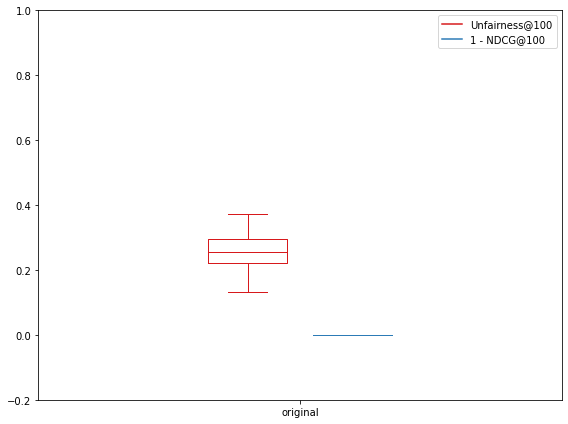

In [0]:
with open(hyper_params['model_file_name'], 'rb') as f: model = torch.load(f)

ufairs_arr = []
ndcgs_arr = []
num_users = 200
num_items = 50
num_rounds = 2

test_reader, total_items = load_data2(hyper_params)

for s_noise in range(0, 5):

  hyper_params['total_items'] = total_items
  hyper_params['testing_batch_limit'] = test_reader.num_b
  criterion = VAELoss(hyper_params)
  metrics, len_to_ndcg_at_100_map,decoder_output_arr,decoder_output_arr2,decoder_output_list  = evaluate2(model, criterion, test_reader, hyper_params, False, num_rounds)
  final_pred = decoder_output_list
  #print(final_pred.shape)
  final_pred = np.array(final_pred)
  print(final_pred.shape)
  preds_k_rounds_filter = np.zeros((num_rounds,num_users,num_items))
  for user in range(num_users):

    preds_k_rounds_filter[:,user,:] = final_pred[:,user,sorted(topkItens[user,:])]
  preds_k_rounds_filter = np.array(preds_k_rounds_filter)
  #print(preds_k_rounds_filter.shape) 
  ufairs, ndcgs = Fairness_at_k_rounds(preds_k_rounds_filter, dcg_gt)
  print("For Noise = "+ str(s_noise))
  #print("Final NDCGs: ",ndcgs)
  print(np.mean(ufairs),np.std(ufairs),np.mean(ndcgs),np.std(ndcgs))
  #plot_comparison([ufairs],[1-ndcgs],['original'],'dataset','test_file')
  ufairs_arr.append(ufairs)
  ndcgs_arr.append(ndcgs) 

plot_comparison([ufairs_arr[0]],[1-ndcgs_arr[0]],['original'],'dataset','test_file')
    


plot_comparison([ufairs_arr[1]],[1-ndcgs_arr[1]],['N(std=0.5)'],'dataset','test_file')



plot_comparison([ufairs_arr[2]],[1-ndcgs_arr[2]],['N(std=1)'],'dataset','test_file')



plot_comparison([ufairs_arr[3]],[1-ndcgs_arr[3]],['N(std=2)'],'dataset','test_file')



plot_comparison([ufairs_arr[4]],[1-ndcgs_arr[4]],['uniform'],'dataset','test_file') 
plot_comparison([ufairs_arr[0],ufairs_arr[1], ufairs_arr[2], ufairs_arr[3], ufairs_arr[4]],[1-ndcgs_arr[0],1-ndcgs_arr[1], 1-ndcgs_arr[2],1-ndcgs_arr[3],1-ndcgs_arr[4]],['original','N(std=0.5)','N(std=1.0)','N(std=2.0)','uniform'], 'dataset', 'test_file')

  

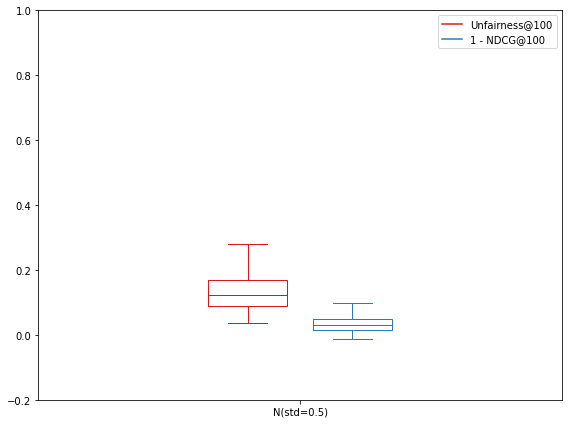

In [0]:
plot_comparison([ufairs_arr[1]],[1-ndcgs_arr[1]],['N(std=0.5)'],'dataset','test_file')

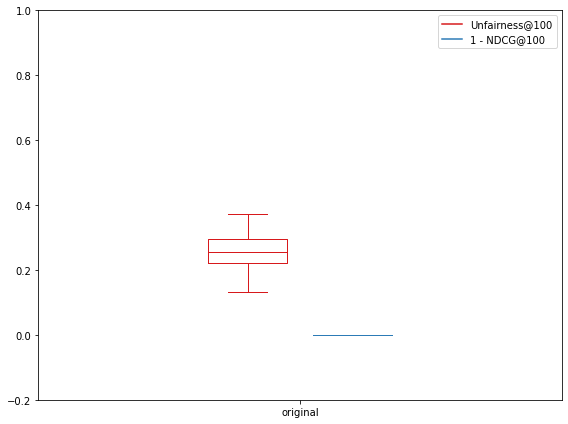

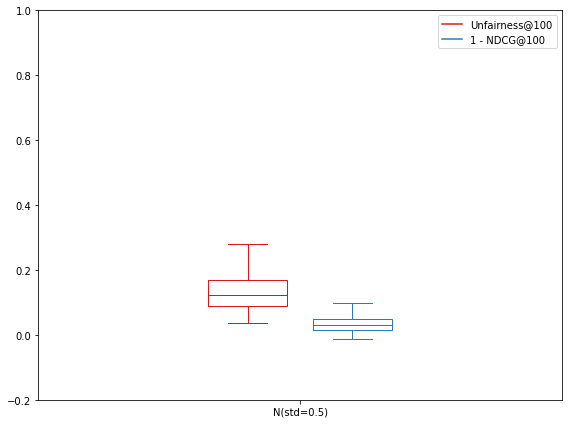

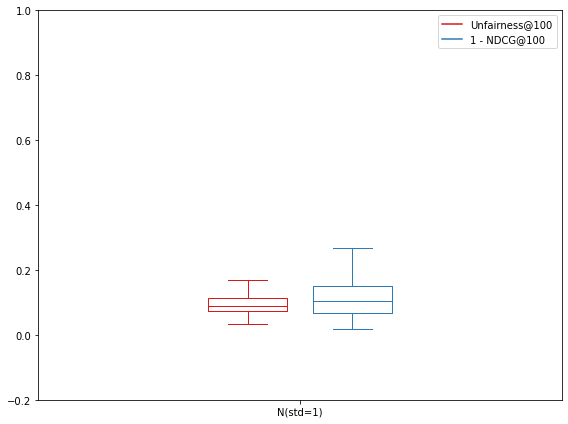

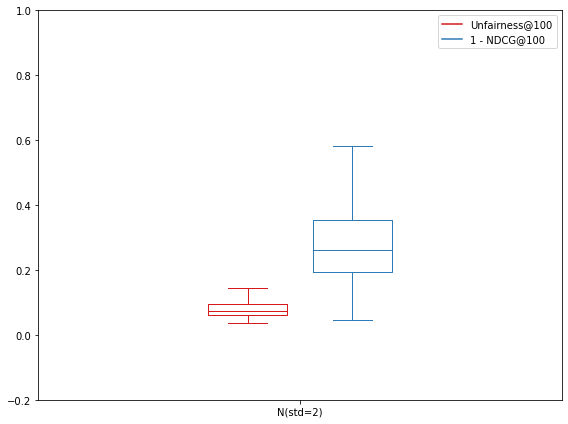

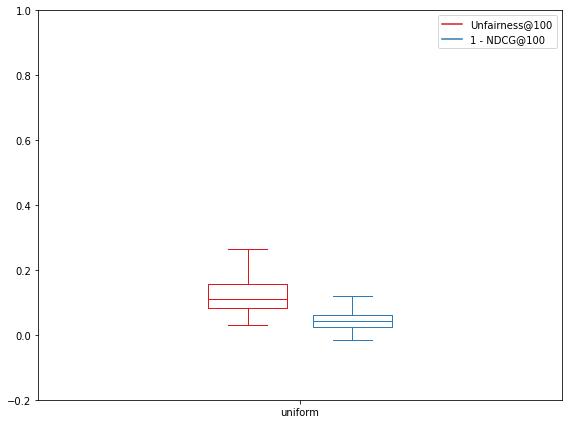

In [0]:
plot_comparison([ufairs_arr[0]],[1-ndcgs_arr[0]],['original'],'dataset','test_file')
    


plot_comparison([ufairs_arr[1]],[1-ndcgs_arr[1]],['N(std=0.5)'],'dataset','test_file')



plot_comparison([ufairs_arr[2]],[1-ndcgs_arr[2]],['N(std=1)'],'dataset','test_file')



plot_comparison([ufairs_arr[3]],[1-ndcgs_arr[3]],['N(std=2)'],'dataset','test_file')



plot_comparison([ufairs_arr[4]],[1-ndcgs_arr[4]],['uniform'],'dataset','test_file') 